# Estimating COVID-19's $R_t$ in Real-Time for all US counties

Modified version of the work by [Kevin Systrom](https://github.com/k-sys/covid-19) to estimate $R_t$ for all US states based on the [NYT](https://github.com/nytimes/covid-19-data) county level data

In [88]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'
theano.config.cxx = ""

## Load COUNTY Information

In [89]:
# Import NYT data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
counties = pd.read_csv(url,parse_dates=['date']).sort_index()
#counties[counties.county != 'Unknown']
counties=counties[counties.county != 'Unknown']
counties.insert(0, 'key', counties['state'] + '_' + counties['county'])
counties.set_index(['key', 'date'],inplace=True)

# Example
#print(counties[counties['state'] == "Maine"]['county'].unique())
print(counties.head())



county       state     fips  cases  deaths
key                  date                                                     
Washington_Snohomish 2020-01-21  Snohomish  Washington  53061.0      1       0
                     2020-01-22  Snohomish  Washington  53061.0      1       0
                     2020-01-23  Snohomish  Washington  53061.0      1       0
Illinois_Cook        2020-01-24       Cook    Illinois  17031.0      1       0
Washington_Snohomish 2020-01-24  Snohomish  Washington  53061.0      1       0


## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [90]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
        print(sys.exc_info()[0])
else:
    print('Already downloaded CSV')

Already downloaded CSV


#### Parse & Clean Patient Info

In [91]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

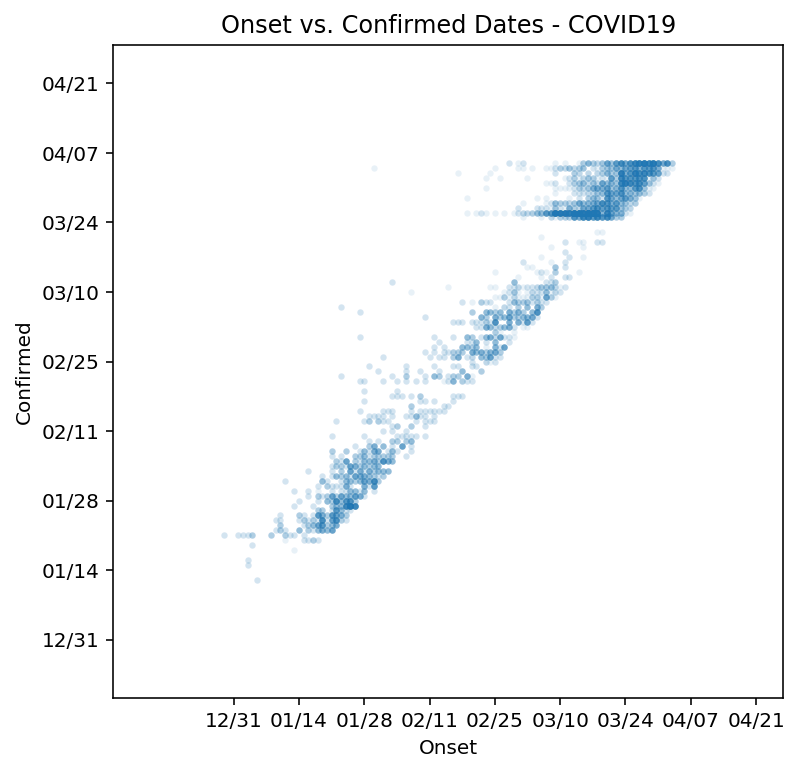

In [92]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

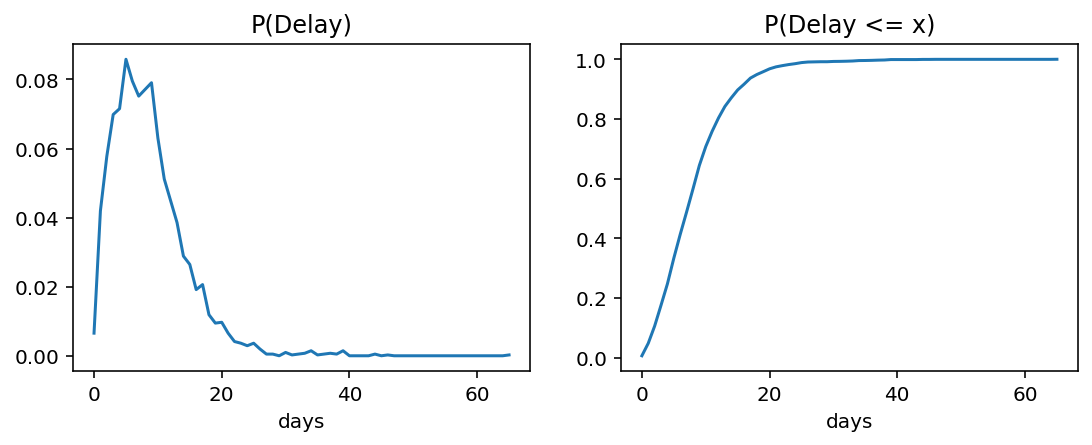

In [93]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

# A single County

In [94]:
key = 'Pennsylvania_Montgomery'
confirmed = counties.xs(key).cases.diff().dropna().clip(0) # new cases (not cumulative)
confirmed.tail()

date
2020-04-28    226.0
2020-04-29    134.0
2020-04-30    130.0
2020-05-01     99.0
2020-05-02     81.0
Name: cases, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [95]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset



In [96]:
# onset for the selected county
onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [97]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay

In [98]:
# adjusted for the selected county
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

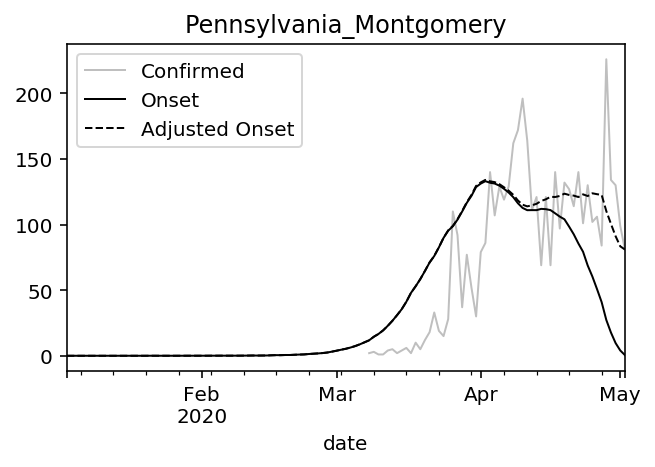

In [99]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=key,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [100]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=50):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [101]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

In [102]:
def create_and_run_model_counties(name, county):
    confirmed = county.cases.diff().dropna().clip(0) # new cases (not cumulative)
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [103]:
print(counties[counties.state== 'Pennsylvania']['county'].unique())

['Delaware' 'Wayne' 'Montgomery' 'Monroe' 'Philadelphia' 'Bucks'
 'Northampton' 'Pike' 'Chester' 'Cumberland' 'Washington' 'Allegheny'
 'Lehigh' 'Luzerne' 'Beaver' 'Adams' 'Berks' 'Lackawanna' 'York'
 'Lancaster' 'Lebanon' 'Westmoreland' 'Centre' 'Erie' 'Franklin' 'Potter'
 'Butler' 'Montour' 'Columbia' 'Dauphin' 'Fayette' 'Mercer' 'Schuylkill'
 'Cambria' 'Armstrong' 'Bradford' 'Carbon' 'Clearfield' 'Juniata'
 'Somerset' 'Greene' 'Lawrence' 'Lycoming' 'Warren' 'Blair' 'Crawford'
 'Indiana' 'Susquehanna' 'Northumberland' 'Union' 'Cameron' 'Clarion'
 'Huntingdon' 'McKean' 'Perry' 'Snyder' 'Tioga' 'Mifflin' 'Venango'
 'Bedford' 'Forest' 'Clinton' 'Sullivan' 'Wyoming' 'Fulton' 'Elk'
 'Jefferson']


In [104]:
counties.columns

Index(['county', 'state', 'fips', 'cases', 'deaths'], dtype='object')

In [105]:
models = {}
countiesToInclude = ['Montgomery','Chester']
#for state_county, grp in counties[counties['state']=='Pennsylvania'].groupby(level='key'): # only the selected state
for state_county, grp in counties[(counties['state']=='Pennsylvania') & (counties['county'].isin(countiesToInclude))].groupby(level='key'): # only the selected state
#for state_county, grp in counties.groupby(level='key'): # all counties all states

    print(state_county)
    #print(grp.droplevel(0))
    if state_county in models:
        print(f'Skipping {state_county}, already in cache')
        continue
    models[state_county] = create_and_run_model_counties(state_county,grp.droplevel(0))

Pennsylvania_Chester
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [37:35<00:00,  1.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Pennsylvania_Montgomery
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [41:59<00:00,  1.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [106]:
countiesToInclude = ['Montgomery','Chester','Philadelphia','Berks']
#for state_county, grp in counties[counties['state']=='Pennsylvania'].groupby(level='key'): # only the selected state
for state_county, grp in counties[(counties['state']=='Pennsylvania') & (counties['county'].isin(countiesToInclude))].groupby(level='key'): # only the selected state
#for state_county, grp in counties.groupby(level='key'): # all counties all states

    print(state_county)
    #print(grp.droplevel(0))
    if state_county in models:
        print(f'Skipping {state_county}, already in cache')
        continue
    models[state_county] = create_and_run_model_counties(state_county,grp.droplevel(0))

Pennsylvania_Berks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [43:41<00:00,  1.53it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Pennsylvania_Chester
Skipping Pennsylvania_Chester, already in cache
Pennsylvania_Montgomery
Skipping Pennsylvania_Montgomery, already in cache
Pennsylvania_Philadelphia
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [1:02:14<00:00,  1.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [107]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


Series([], dtype: int64)

## Compile Results

In [108]:
results = None

for state_county, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

In [126]:
results.loc[results.index.get_level_values('region') == 'Pennsylvania_Montgomery'].tail(14)
#results[results['region'] == 'Pennsylvania_Montgomery'].tail()

mean    median  lower_90  upper_90  \
region                  date                                                 
Pennsylvania_Montgomery 2020-04-19  1.021311  1.024724  0.851173  1.223137   
                        2020-04-20  1.014763  1.020180  0.819307  1.194721   
                        2020-04-21  1.017065  1.017442  0.841306  1.233317   
                        2020-04-22  1.015147  1.017914  0.819875  1.209210   
                        2020-04-23  1.011386  1.017311  0.810908  1.217957   
                        2020-04-24  1.007792  1.011685  0.790545  1.225679   
                        2020-04-25  1.007370  1.011149  0.807577  1.248435   
                        2020-04-26  1.004010  1.012766  0.773182  1.227872   
                        2020-04-27  1.004576  1.012462  0.781074  1.259232   
                        2020-04-28  1.003218  1.009531  0.759133  1.258573   
                        2020-04-29  1.000164  1.014627  0.701594  1.240919   
                        2020-04-30  0.997764  1.015676  0.729293  1.289458   
                        2020-05-01  0.996275  1.014144  0.730708  1.296845   
                        2020-05-02  0.998408  1.015493  0.701196  1.297063   

                                    lower_50  upper_50  
region                  date                            
Pennsylvania_Montgomery 2020-04-19  0.950426  1.071906  
                        2020-04-20  0.939173  1.067133  
                        2020-04-21  0.940986  1.067652  
                        2020-04-22  0.947555  1.080242  
                        2020-04-23  0.934447  1.070560  
                        2020-04-24  0.930566  1.072214  
                        2020-04-25  0.937856  1.081090  
                        2020-04-26  0.931869  1.084587  
                        2020-04-27  0.915885  1.071837  
                        2020-04-28  0.942415  1.106951  
                        2020-04-29  0.938150  1.106683  
                        2020-04-30  0.936910  1.118359  
                        2020-05-01  0.909105  1.092649  
                        2020-05-02  0.948613  1.127712

### Render to CSV

### Render Charts

In [111]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(-1, 2) # change y-axis limits
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_50'].values,
        result['upper_50'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

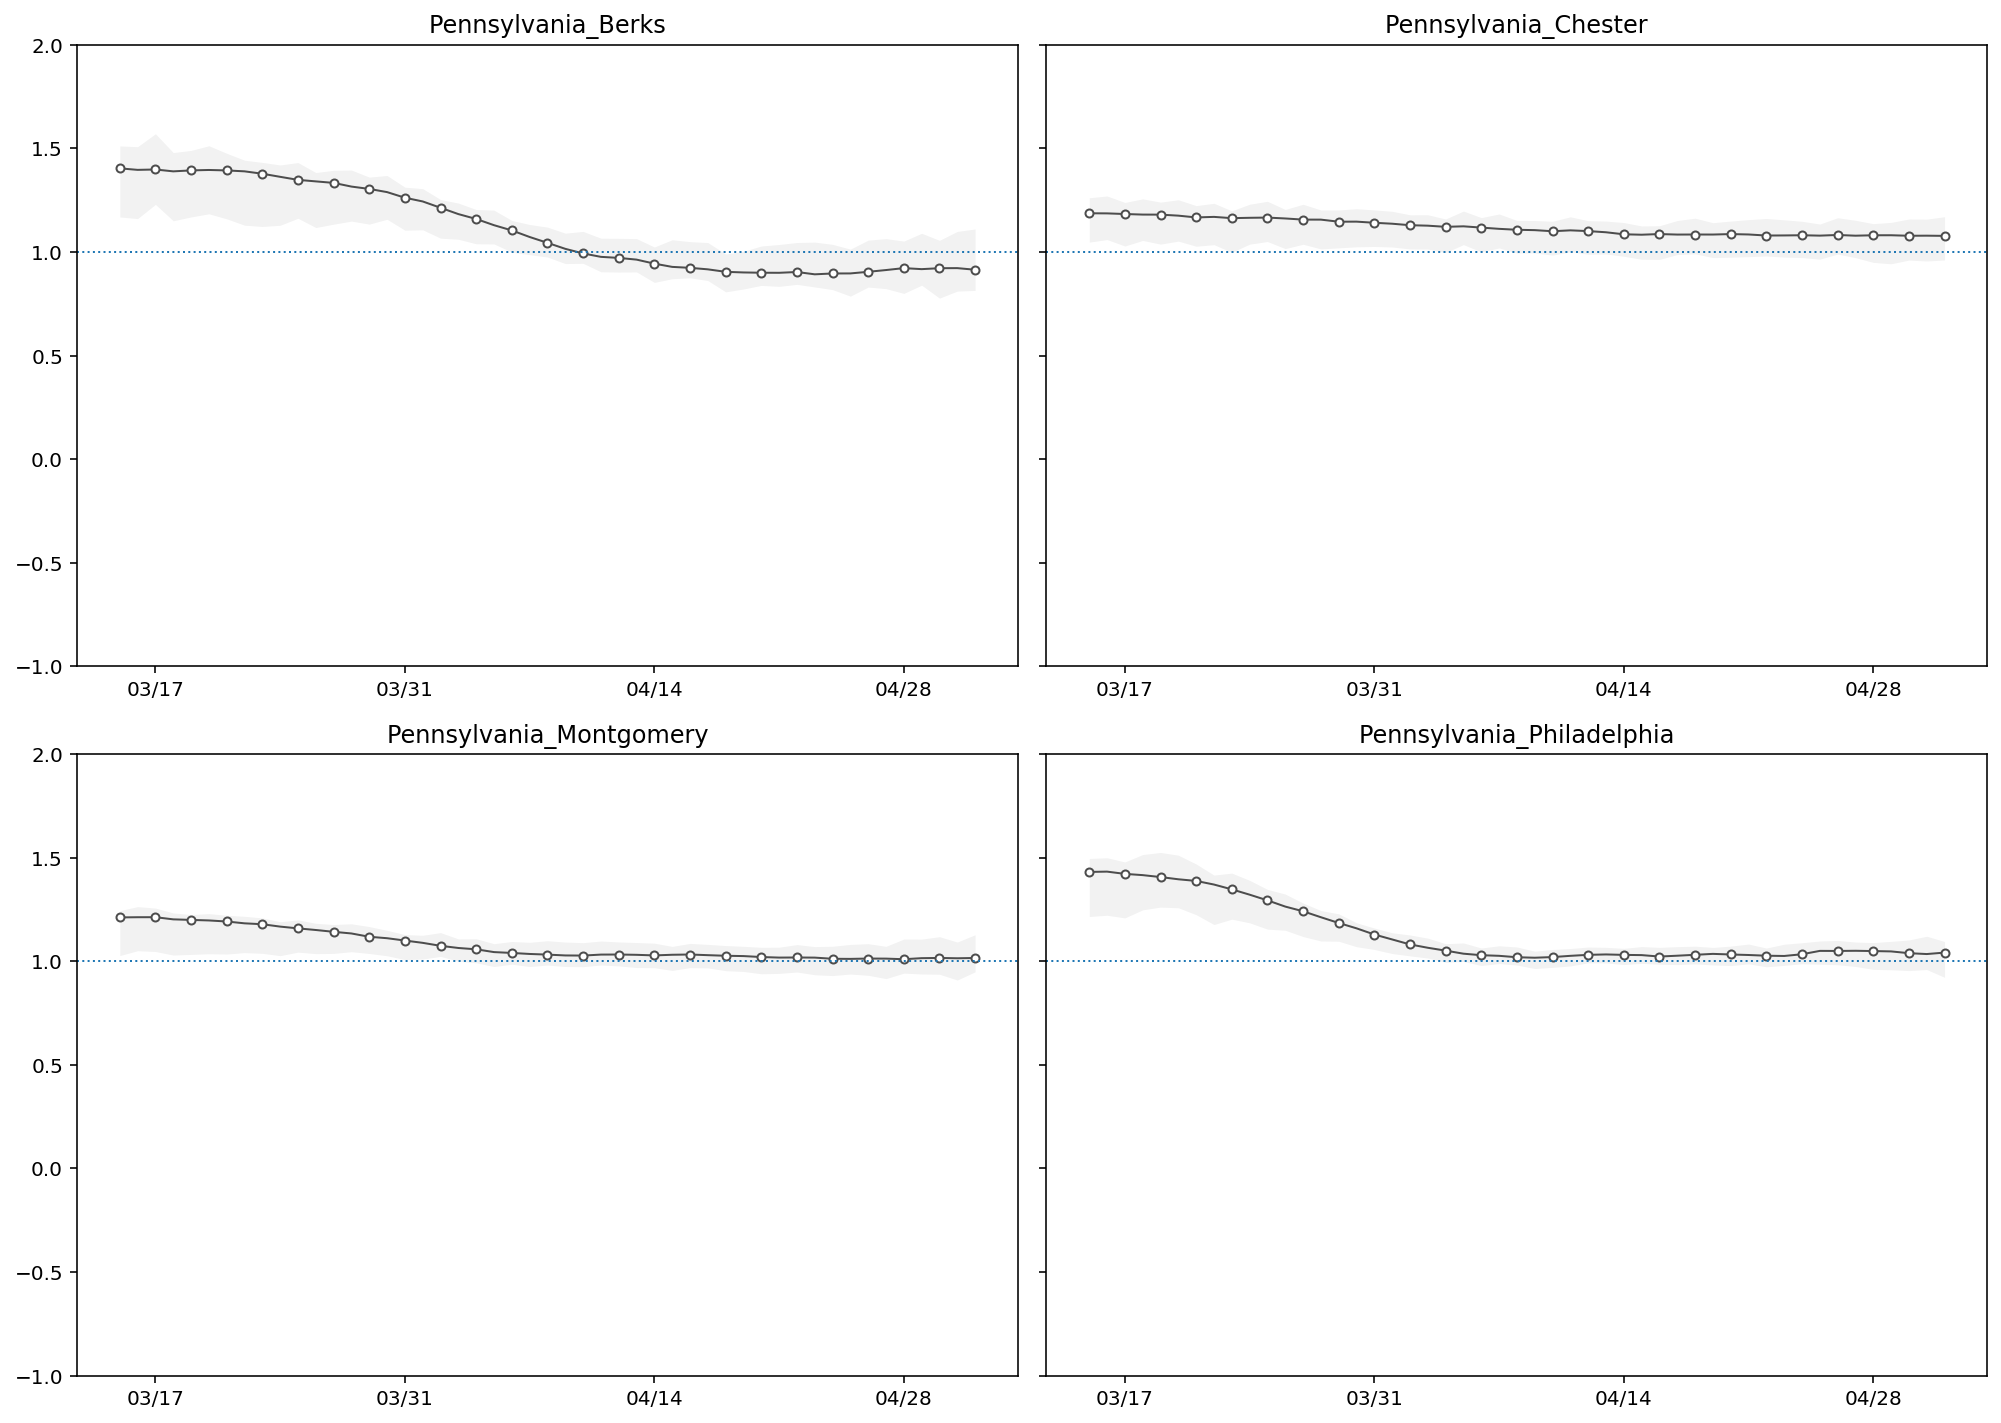

In [112]:
ncols = 2
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*5),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')